<a href="https://colab.research.google.com/github/atahanoezer/Wind/blob/main/Notebooks/UEBB_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads

In [1]:
!pip install catboost

In [2]:
!pip install optuna

In [5]:
import os
directory_path = "datasets/Brazil"
url = "https://zenodo.org/record/1475197/files/UEBB_v1.nc?download=1"
file_name = "UEBB_v1.nc"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Use wget to download the file
!wget -O "{os.path.join(directory_path, file_name)}" "{url}"

--2023-09-03 10:36:30--  https://zenodo.org/record/1475197/files/UEBB_v1.nc?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162776597 (155M) [application/octet-stream]
Saving to: ‘datasets/Brazil/UEBB_v1.nc’

datasets/Brazil/UEB 100%[===================>] 155.24M  6.43MB/s    in 51s     

2023-09-03 10:37:23 (3.07 MB/s) - ‘datasets/Brazil/UEBB_v1.nc’ saved [162776597/162776597]



# Imports

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
%matplotlib inline

from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [7]:
! git clone https://github.com/atahanoezer/Wind.git

fatal: destination path 'Wind' already exists and is not an empty directory.


In [8]:
from Wind.dataset import Dataset
from Wind.utils import experiment_results
from Wind.model import *

In [9]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [10]:
uebb = 'datasets/Brazil/UEBB_v1.nc'
ds = xr.open_dataset(uebb)
df = ds.to_dataframe()
df =df.loc[(df.index.get_level_values('Turbine') == 1.0) & (df.index.get_level_values('Height') == 60.0)]
df = df.reset_index()
df['Time']=pd.to_datetime(df['Time'])
df = df.set_index('Time')

In [11]:
test_time = pd.to_datetime('2014-05-18 18:50:00')
df_test = df[df.index >= test_time]
test_split = len(df_test)/len(df)

Following fields are observed via pandas profiling, reports can be generated by running the profiler function in utils.py

In [12]:
high_empty_fields = ['wind_direction_std','air_temperature','relative_humidity', 'UST','UST_flag', 'HS','HS_flag', 'TKE',
                     'LMO','ws_w_corrected'] #
missing_fields = ['wind_speed','wind_direction','wind_speed_std','wind_speed_max','wind_speed_min',
                         'wind_speed_cube','air_pressure','logger_temperature', 'battery_V','ws_u','ws_v','ws_w',
                         'tilt_X','tilt_Y','tilt_X_std','tilt_Y_std','wind_speed_nacelle','wind_speed_nacelle_max',
                         'wind_speed_nacelle_min','rotor_rpm','rotor_rpm_max','rotor_rpm_min','active_power_total',
                         'active_power_total_max','active_power_total_min','act_position','air_density']

In [13]:
roll_window = 4
dataset = Dataset(df)
dataset.fill_nan(missing_fields)
dataset.drop_nan(high_empty_fields)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
dataset.apply_rolling_window(dataset.df,'wind_speed', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'air_pressure', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'rotor_rpm', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'wind_speed_nacelle', roll_window,np.mean)

# One-Shot Modelling



## Next Step Prediction



In [66]:
window = 48
horizon =1
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate = False
                                                                     ,val_split = 0.1)

### Default

In [67]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.091607
0:	learn: 212.2191126	test: 241.4391529	best: 241.4391529 (0)	total: 30.5ms	remaining: 30.4s
500:	learn: 44.7534817	test: 35.9710241	best: 35.9323576 (478)	total: 9.05s	remaining: 9.01s
999:	learn: 42.6539732	test: 36.1520853	best: 35.9323576 (478)	total: 18.2s	remaining: 0us
bestTest = 35.9323576
bestIteration = 478
Shrink model to first 479 iterations.


                  MAE       RMSE        R2
Validation  21.332993  35.932354  0.919593
Test        34.104793  52.417468  0.937889


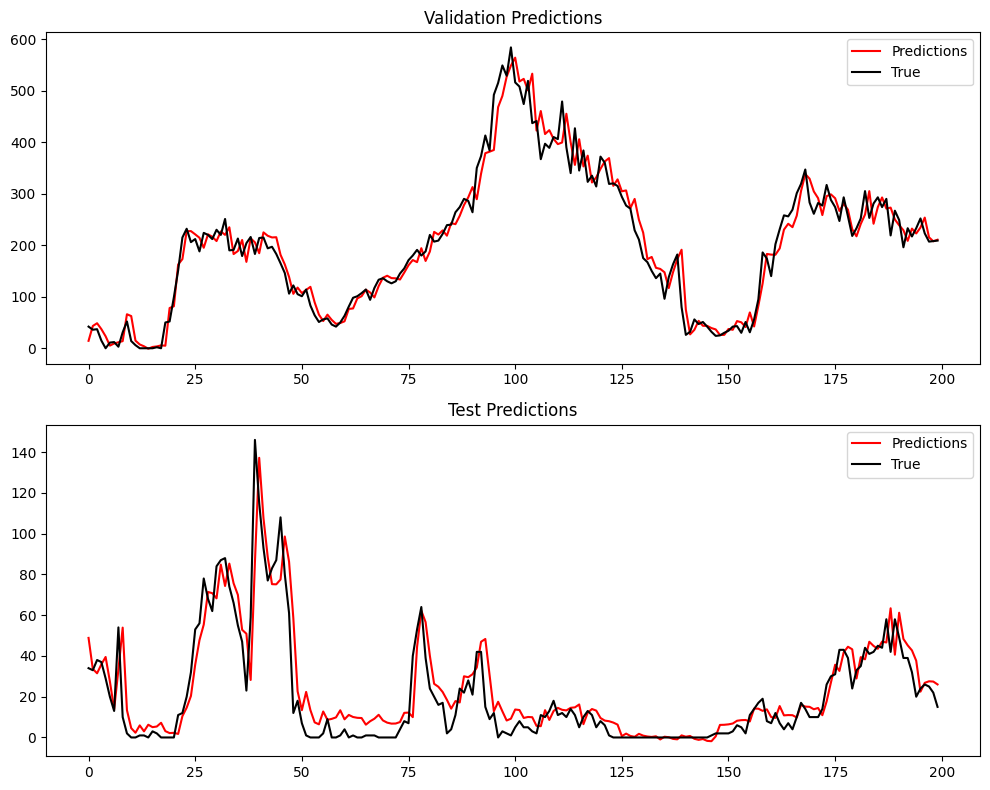

In [68]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Feat Select

In [15]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y,num_feats = 52,plot= True)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.091607
0:	learn: 212.1888531	test: 241.1427008	best: 241.1427008 (0)	total: 15ms	remaining: 15s
500:	learn: 44.8254810	test: 36.0366828	best: 36.0366828 (500)	total: 9.13s	remaining: 9.1s
999:	learn: 42.6330258	test: 35.8972948	best: 35.8514436 (764)	total: 18.1s	remaining: 0us
bestTest = 35.8514436
bestIteration = 764
Shrink model to first 765 iterations.


                  MAE       RMSE        R2
Validation  21.161716  35.851442  0.919955
Test        33.557529  51.982834  0.938914


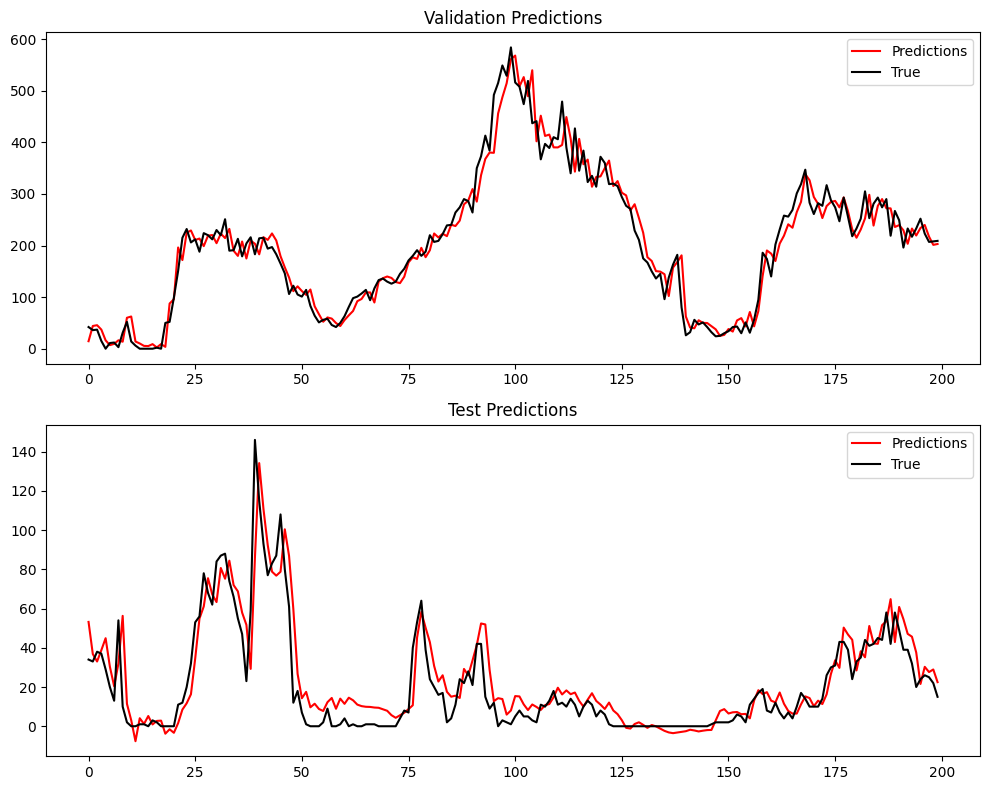

In [17]:
next_step_os_feat,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Hyp-op

In [18]:
model.hyp_op(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y, task_type = 'GPU')

[I 2023-09-03 10:42:55,871] A new study created in memory with name: no-name-5f3b7e5b-3672-4161-8d03-0842fecfb7a2
[I 2023-09-03 10:43:09,329] Trial 0 finished with value: 58.5673718235285 and parameters: {'learning_rate': 0.0016825963456210161, 'depth': 5, 'min_data_in_leaf': 33}. Best is trial 0 with value: 58.5673718235285.
[I 2023-09-03 10:43:18,076] Trial 1 finished with value: 23.13686732836089 and parameters: {'learning_rate': 0.08029798997391233, 'depth': 1, 'min_data_in_leaf': 54}. Best is trial 1 with value: 23.13686732836089.
[I 2023-09-03 10:44:15,285] Trial 2 finished with value: 32.14262452094658 and parameters: {'learning_rate': 0.002668741420563383, 'depth': 9, 'min_data_in_leaf': 30}. Best is trial 1 with value: 23.13686732836089.
[I 2023-09-03 10:44:26,947] Trial 3 finished with value: 35.61350711586223 and parameters: {'learning_rate': 0.0025736968618288066, 'depth': 4, 'min_data_in_leaf': 76}. Best is trial 1 with value: 23.13686732836089.
[I 2023-09-03 10:45:02,655]

Best hyperparameters: {'learning_rate': 0.03135216818675589, 'depth': 10, 'min_data_in_leaf': 55}
Best RMSE: 20.840296842317905


({'learning_rate': 0.03135216818675589, 'depth': 10, 'min_data_in_leaf': 55},
 20.840296842317905)

                  MAE       RMSE        R2
Validation  21.054405  35.560880  0.921247
Test        33.532101  51.870279  0.939179


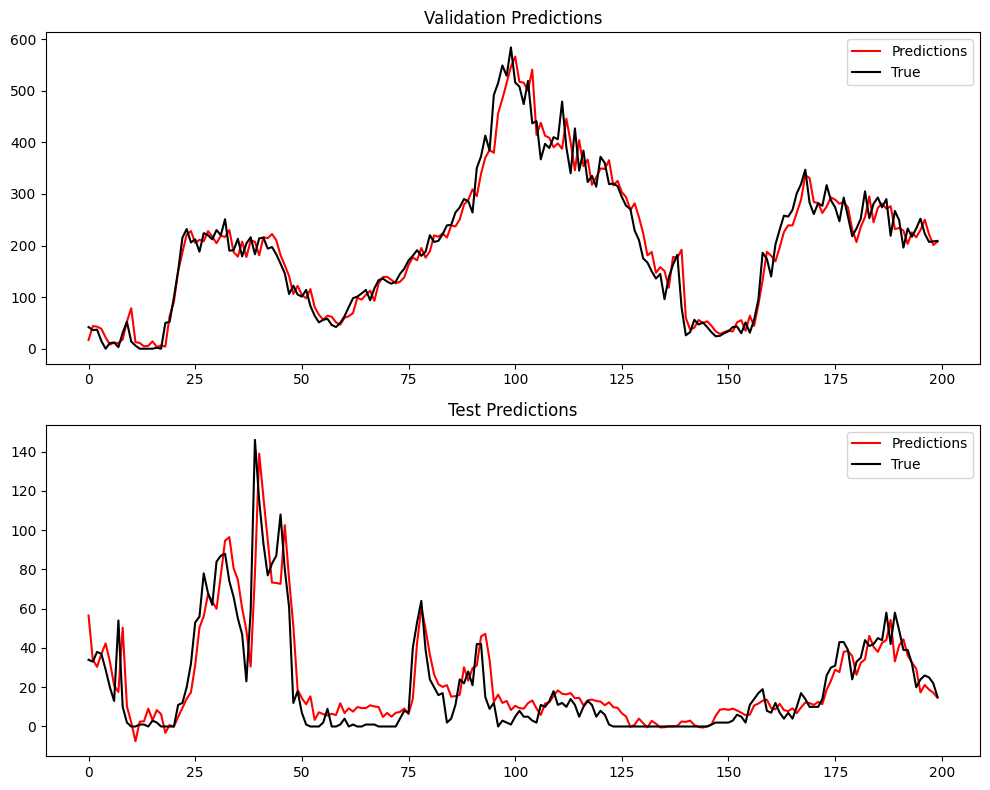

In [22]:
next_step_os_feat_hy,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Hyp-op Transfer

In [23]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64})
model.train(train_x, train_y, val_x, val_y)

0:	learn: 218.6642327	test: 248.9423594	best: 248.9423594 (0)	total: 107ms	remaining: 1m 47s
500:	learn: 44.7187913	test: 35.8806433	best: 35.8621526 (464)	total: 24.3s	remaining: 24.2s
999:	learn: 41.9190142	test: 35.5783003	best: 35.5608842 (882)	total: 50.7s	remaining: 0us
bestTest = 35.56088418
bestIteration = 882
Shrink model to first 883 iterations.


                  MAE       RMSE        R2
Validation  21.054405  35.560880  0.921247
Test        33.532101  51.870279  0.939179


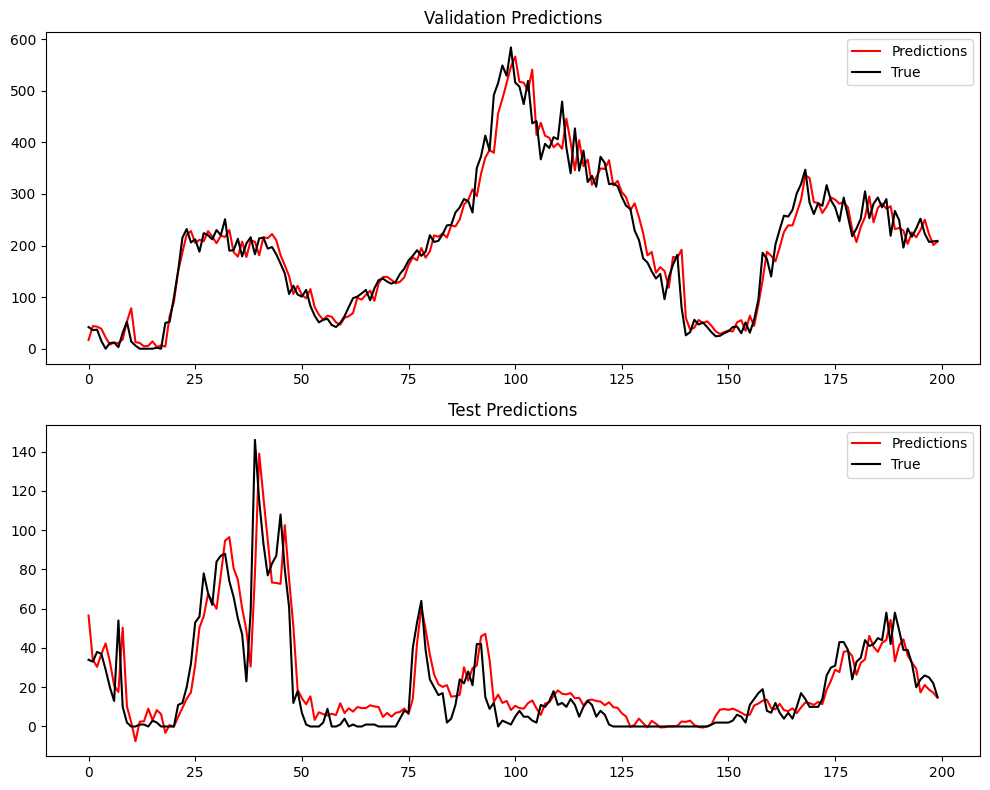

In [24]:
next_step_os_transfer,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



## Next Hour Prediction



### Default

In [33]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y, columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,val_split = 0.1)

In [26]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091606
0:	learn: 216.3626917	test: 244.1634301	best: 244.1634301 (0)	total: 29.3ms	remaining: 29.3s
500:	learn: 84.3092826	test: 70.7783965	best: 70.6920358 (445)	total: 10.4s	remaining: 10.3s
999:	learn: 77.5455105	test: 71.4833875	best: 70.6920358 (445)	total: 18.8s	remaining: 0us
bestTest = 70.69203584
bestIteration = 445
Shrink model to first 446 iterations.


                  MAE        RMSE        R2
Validation  48.274550   70.692043  0.688824
Test        77.657147  110.062459  0.726131


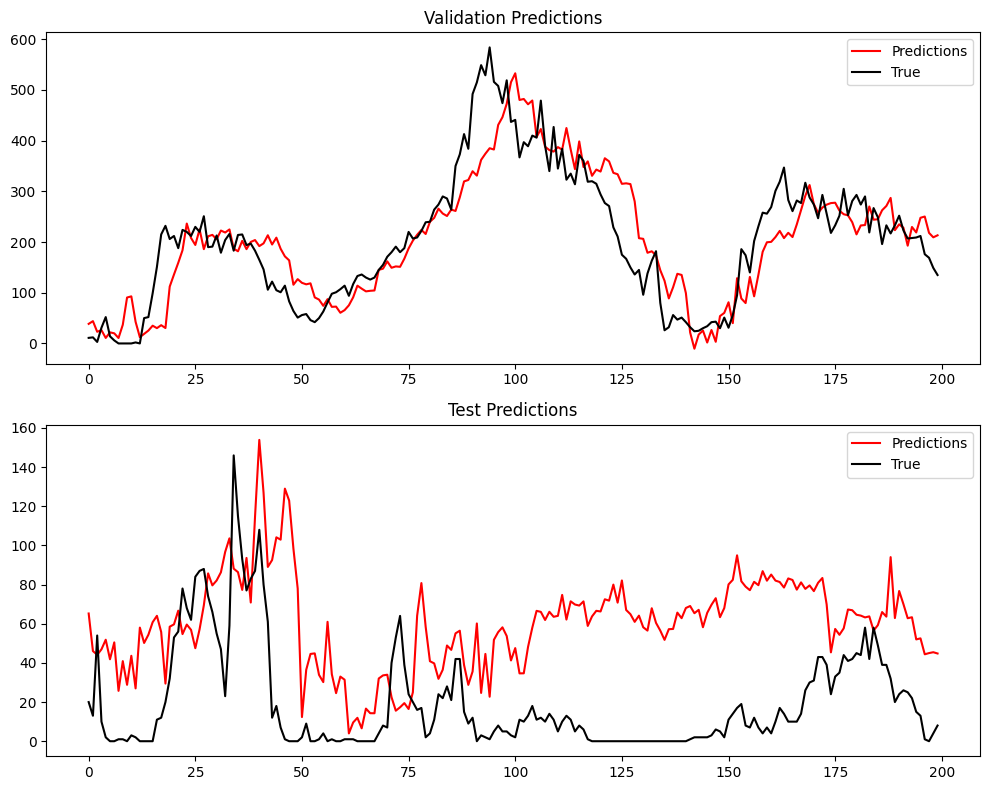

In [27]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [34]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =52,plot= True)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1])

Learning rate set to 0.091606
0:	learn: 216.2774638	test: 245.1658850	best: 245.1658850 (0)	total: 51.6ms	remaining: 51.6s
500:	learn: 85.3450816	test: 70.5579149	best: 70.3442605 (470)	total: 8.17s	remaining: 8.13s
999:	learn: 79.0132588	test: 71.2852358	best: 70.2929285 (540)	total: 17.1s	remaining: 0us
bestTest = 70.29292846
bestIteration = 540
Shrink model to first 541 iterations.


                  MAE        RMSE        R2
Validation  47.793067   70.292929  0.692328
Test        78.138422  110.559800  0.723650


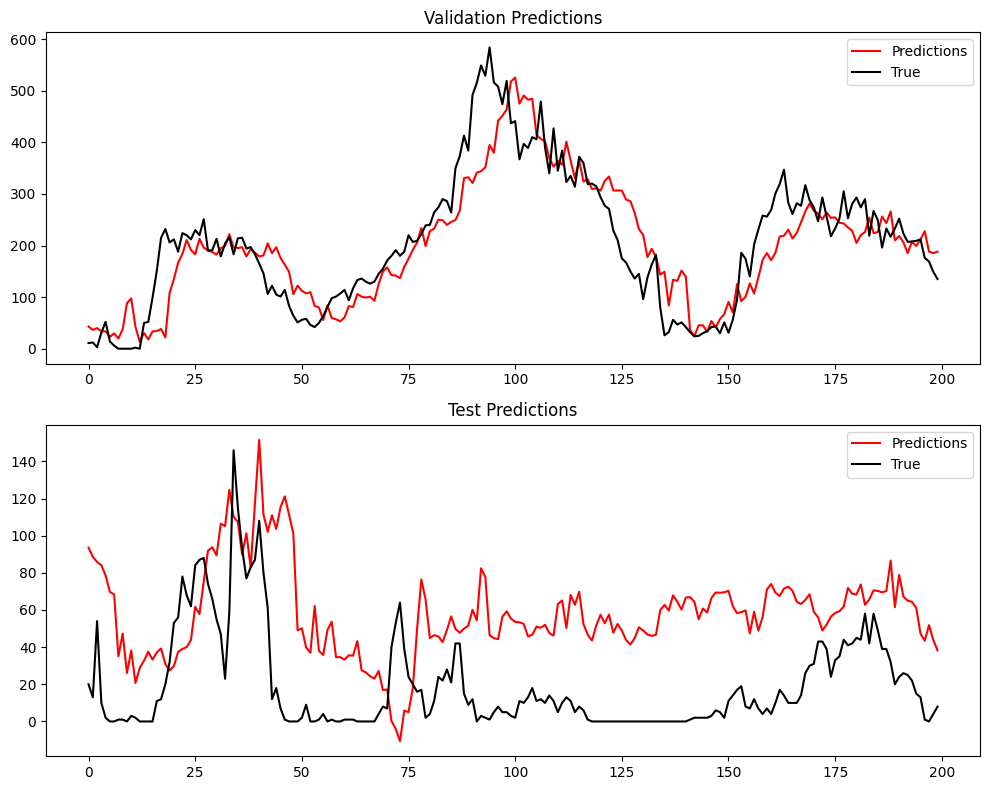

In [30]:
next_hour_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [31]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-03 11:07:28,026] A new study created in memory with name: no-name-9d182f71-71c0-40c6-8c9e-f746497b4535
[I 2023-09-03 11:07:38,962] Trial 0 finished with value: 91.01174126386694 and parameters: {'learning_rate': 0.0017390607232755785, 'depth': 3, 'min_data_in_leaf': 57}. Best is trial 0 with value: 91.01174126386694.
[I 2023-09-03 11:07:45,938] Trial 1 finished with value: 99.31820336232181 and parameters: {'learning_rate': 0.00250033114089347, 'depth': 1, 'min_data_in_leaf': 34}. Best is trial 0 with value: 91.01174126386694.
[I 2023-09-03 11:08:22,612] Trial 2 finished with value: 47.111463267061666 and parameters: {'learning_rate': 0.010421953480960838, 'depth': 8, 'min_data_in_leaf': 52}. Best is trial 2 with value: 47.111463267061666.
[I 2023-09-03 11:08:34,459] Trial 3 finished with value: 48.76930360926284 and parameters: {'learning_rate': 0.014244487007501111, 'depth': 4, 'min_data_in_leaf': 100}. Best is trial 2 with value: 47.111463267061666.
[I 2023-09-03 11:08:44

Best hyperparameters: {'learning_rate': 0.014201773972901259, 'depth': 7, 'min_data_in_leaf': 64}
Best RMSE: 46.845983436111446


({'learning_rate': 0.014201773972901259, 'depth': 7, 'min_data_in_leaf': 64},
 46.845983436111446)

                  MAE        RMSE        R2
Validation  47.659405   70.706548  0.688696
Test        75.731960  106.656628  0.742818


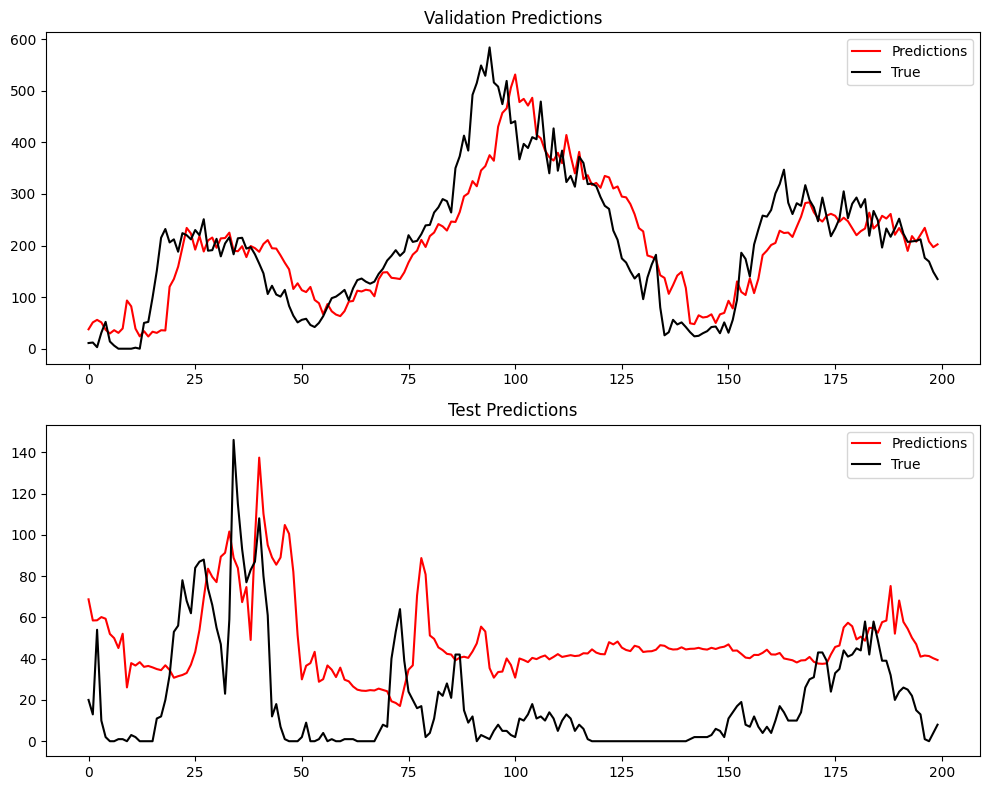

In [32]:
next_hour_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op Transfer

In [35]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.01295853204616923, 'depth': 6, 'min_data_in_leaf': 70})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

0:	learn: 229.2180226	test: 261.1977218	best: 261.1977218 (0)	total: 25.7ms	remaining: 25.7s
500:	learn: 98.1995717	test: 71.8838517	best: 71.8838517 (500)	total: 7.51s	remaining: 7.48s
999:	learn: 94.4646950	test: 70.8909054	best: 70.8900807 (994)	total: 16.2s	remaining: 0us
bestTest = 70.8900807
bestIteration = 994
Shrink model to first 995 iterations.


                  MAE        RMSE        R2
Validation  47.671317   70.890078  0.687078
Test        75.757503  106.963148  0.741338


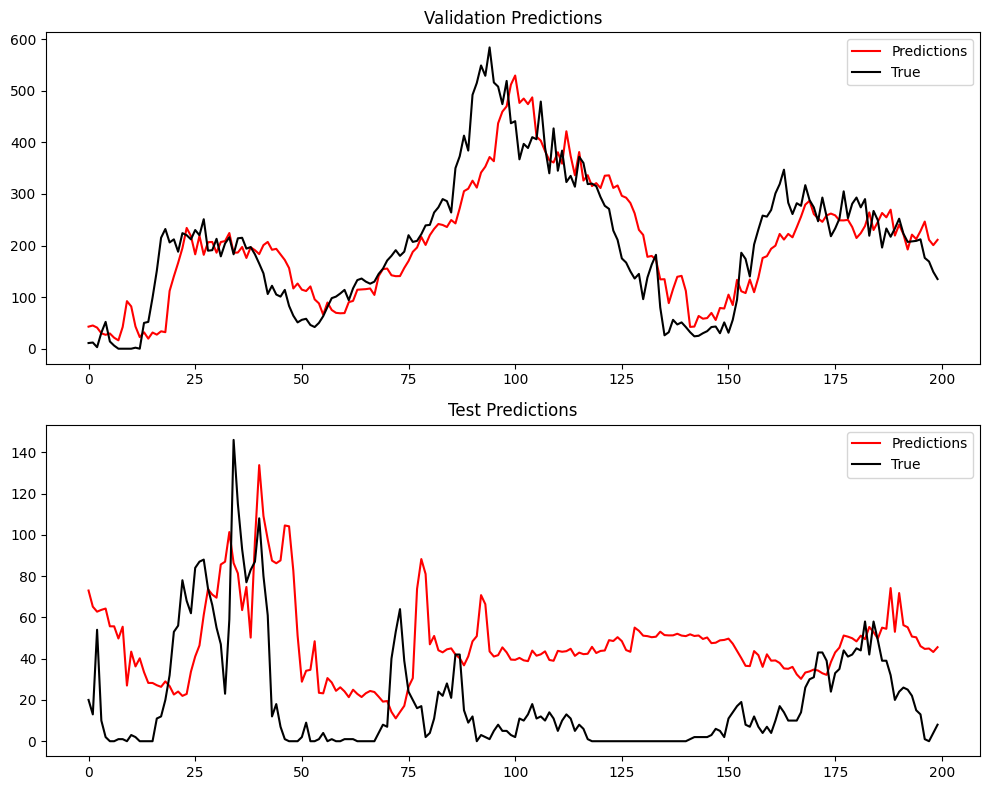

In [36]:
next_hour_os_transfer,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

## Next Day Prediction

In [43]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split,val_split=0.1)

### Default

In [38]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091542
0:	learn: 221.8305069	test: 253.8753265	best: 253.8753265 (0)	total: 48.5ms	remaining: 48.5s
500:	learn: 105.2021357	test: 121.7485297	best: 121.1725554 (493)	total: 14.8s	remaining: 14.8s
999:	learn: 87.3061554	test: 121.2061491	best: 119.5125506 (587)	total: 30.5s	remaining: 0us
bestTest = 119.5125506
bestIteration = 587
Shrink model to first 588 iterations.


                   MAE        RMSE        R2
Validation   93.041024  119.512553  0.097540
Test        152.823973  187.979433  0.196673


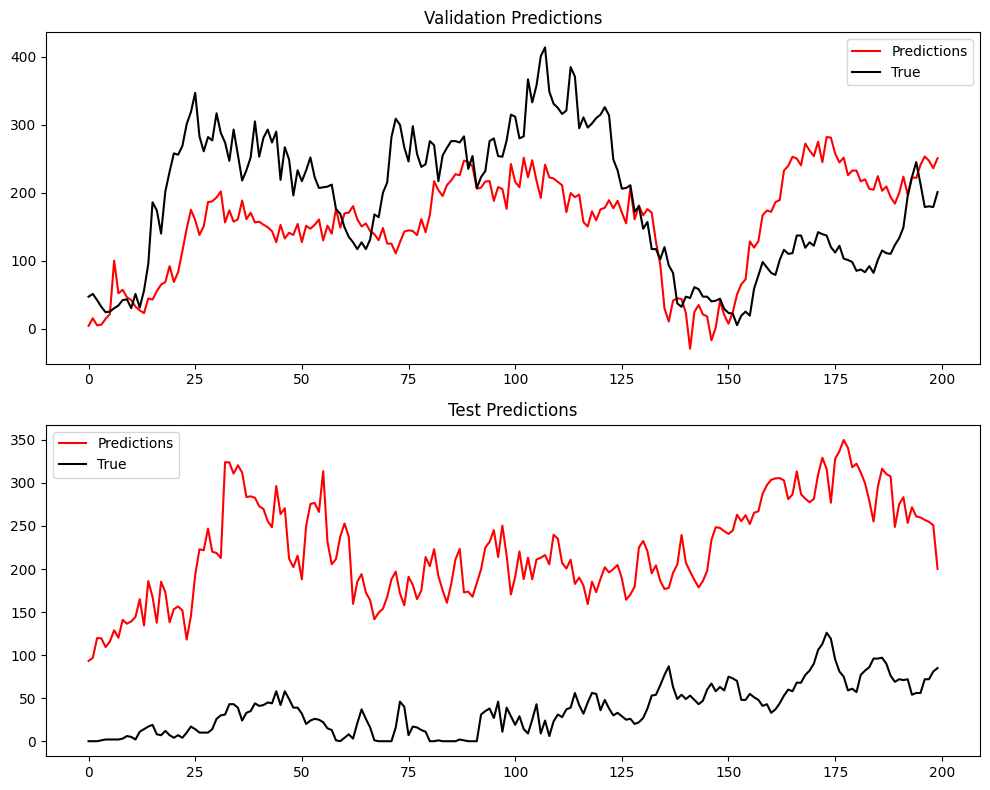

In [39]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [45]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})

feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =52,plot= True)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [46]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091542
0:	learn: 222.1205174	test: 248.8222176	best: 248.8222176 (0)	total: 16.9ms	remaining: 16.9s
500:	learn: 111.3924420	test: 113.2031193	best: 112.6870603 (381)	total: 8.64s	remaining: 8.6s
999:	learn: 96.2001538	test: 116.7992388	best: 112.6870603 (381)	total: 16.5s	remaining: 0us
bestTest = 112.6870603
bestIteration = 381
Shrink model to first 382 iterations.


                   MAE        RMSE        R2
Validation   85.121621  112.687065  0.197678
Test        151.729925  188.445306  0.192686


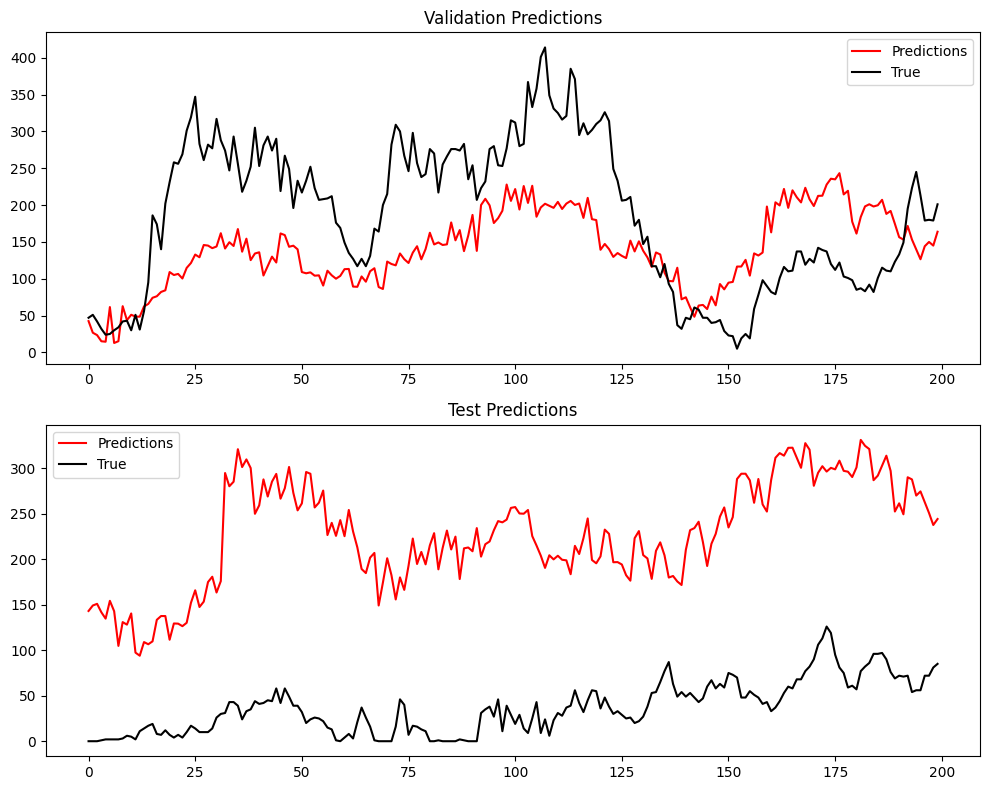

In [47]:
next_day_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [48]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-03 11:39:46,702] A new study created in memory with name: no-name-5859e7b3-568d-4bae-9e3b-fcf1b88c093d
[I 2023-09-03 11:39:56,451] Trial 0 finished with value: 101.22695646258897 and parameters: {'learning_rate': 0.029850538673941187, 'depth': 2, 'min_data_in_leaf': 10}. Best is trial 0 with value: 101.22695646258897.
[I 2023-09-03 11:40:06,380] Trial 1 finished with value: 108.51890390485956 and parameters: {'learning_rate': 0.011048567616897516, 'depth': 2, 'min_data_in_leaf': 76}. Best is trial 0 with value: 101.22695646258897.
[I 2023-09-03 11:40:24,002] Trial 2 finished with value: 110.32072143531309 and parameters: {'learning_rate': 0.0038742475793319075, 'depth': 6, 'min_data_in_leaf': 60}. Best is trial 0 with value: 101.22695646258897.
[I 2023-09-03 11:41:29,033] Trial 3 finished with value: 118.05391155833476 and parameters: {'learning_rate': 0.004097316490643613, 'depth': 9, 'min_data_in_leaf': 56}. Best is trial 0 with value: 101.22695646258897.
[I 2023-09-03 11:

Best hyperparameters: {'learning_rate': 0.04528685027571669, 'depth': 5, 'min_data_in_leaf': 33}
Best RMSE: 78.17986285407716


({'learning_rate': 0.04528685027571669, 'depth': 5, 'min_data_in_leaf': 33},
 78.17986285407716)

                   MAE        RMSE        R2
Validation  103.033104  126.888022 -0.017283
Test        153.282451  186.695876  0.207606


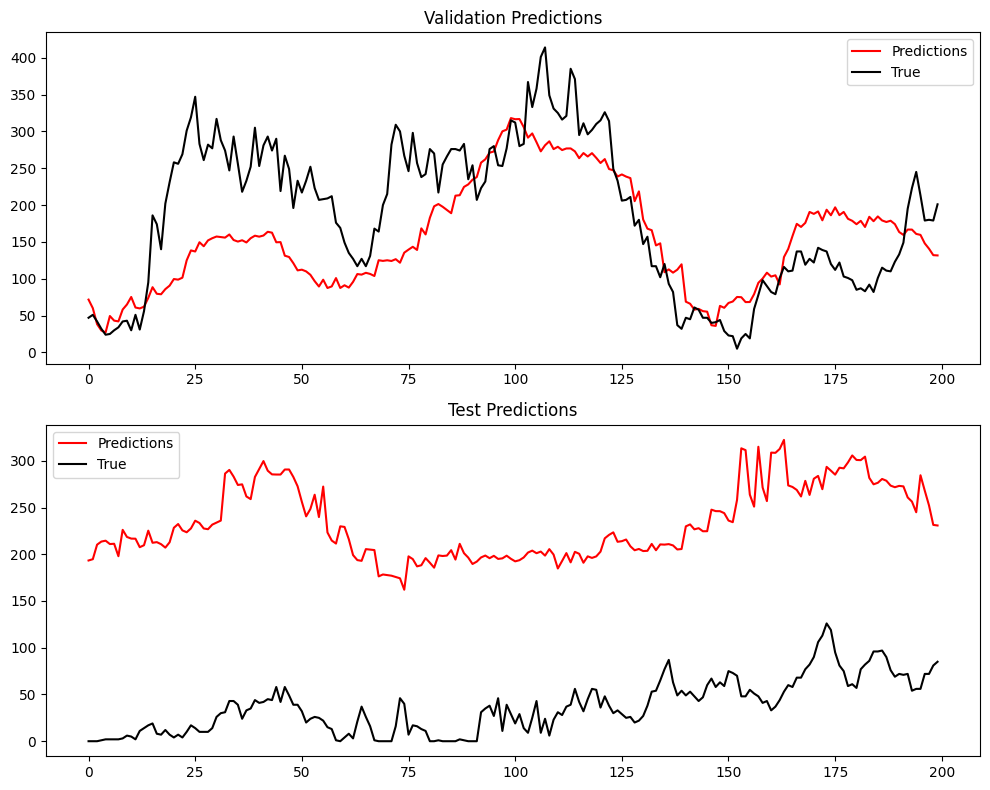

In [51]:
next_day_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op Transfer

In [52]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.0289836229349701, 'depth': 2, 'min_data_in_leaf': 62})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

0:	learn: 229.2490720	test: 260.4804479	best: 260.4804479 (0)	total: 10.7ms	remaining: 10.7s
500:	learn: 160.5467893	test: 129.4636758	best: 129.3208304 (492)	total: 5.83s	remaining: 5.8s
999:	learn: 156.2786053	test: 127.0558520	best: 126.8879919 (966)	total: 9.35s	remaining: 0us
bestTest = 126.8879919
bestIteration = 966
Shrink model to first 967 iterations.


                   MAE        RMSE        R2
Validation  103.033104  126.888022 -0.017283
Test        153.282451  186.695876  0.207606


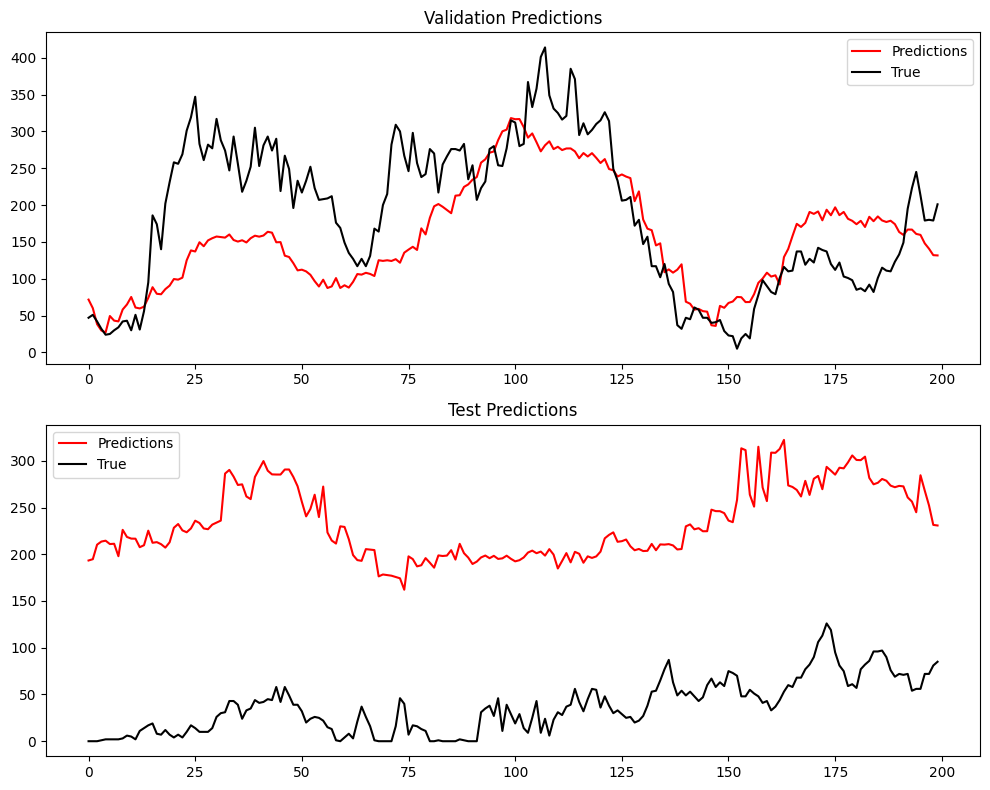

In [53]:
next_day_os_transfer,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

# Recursive Modelling

## Next Hour

In [54]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate= True,val_split=0.1)

### Default Recursive

In [55]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

Learning rate set to 0.091606
0:	learn: 212.4690347	test: 241.0548013	best: 241.0548013 (0)	total: 27.9ms	remaining: 27.9s
500:	learn: 53.9880683	test: 39.5907964	best: 39.5526824 (477)	total: 9.25s	remaining: 9.22s
999:	learn: 51.9025178	test: 39.6462252	best: 39.5526824 (477)	total: 16.8s	remaining: 0us
bestTest = 39.55268237
bestIteration = 477
Shrink model to first 478 iterations.


                  MAE       RMSE        R2
Validation  29.973624  45.626717  0.870392
Test        49.411526  71.510847  0.884390


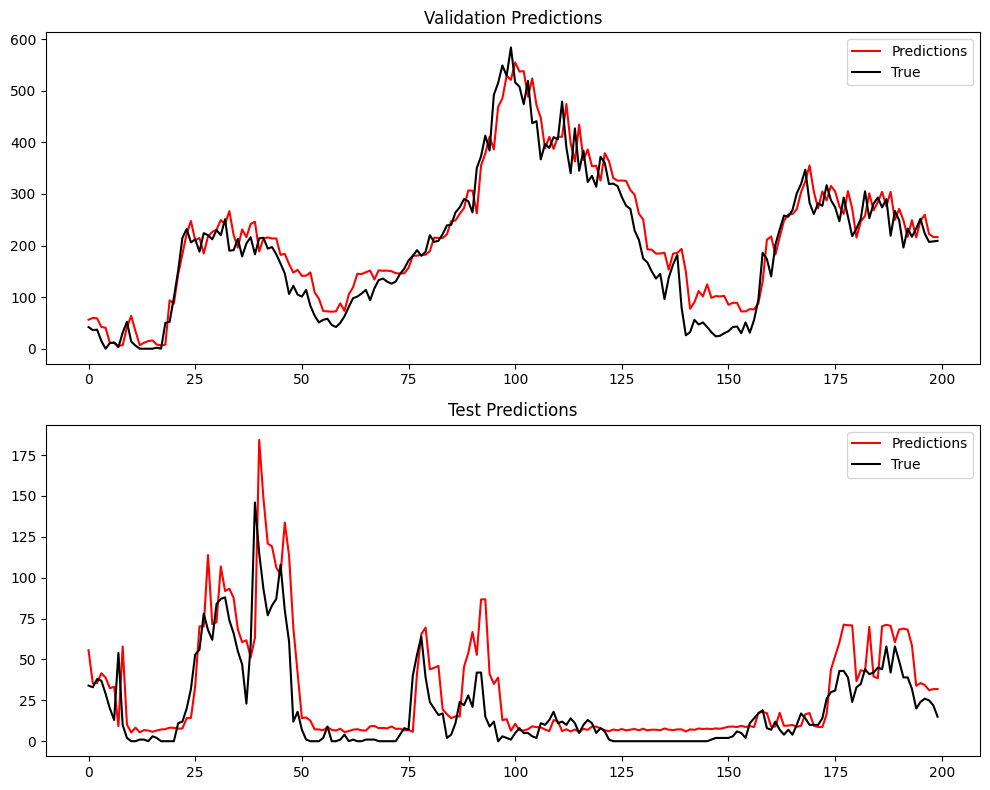

In [56]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)

### Recursive with Transferred Hyp-op

In [57]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

0:	learn: 218.6752048	test: 248.8400759	best: 248.8400759 (0)	total: 117ms	remaining: 1m 56s
500:	learn: 53.0566963	test: 39.5246705	best: 39.5155449 (490)	total: 26.1s	remaining: 26s
999:	learn: 50.6247156	test: 39.5368299	best: 39.5028752 (539)	total: 49.3s	remaining: 0us
bestTest = 39.50287518
bestIteration = 539
Shrink model to first 540 iterations.


                  MAE       RMSE        R2
Validation  30.906826  46.311692  0.866471
Test        50.600275  72.057298  0.882617


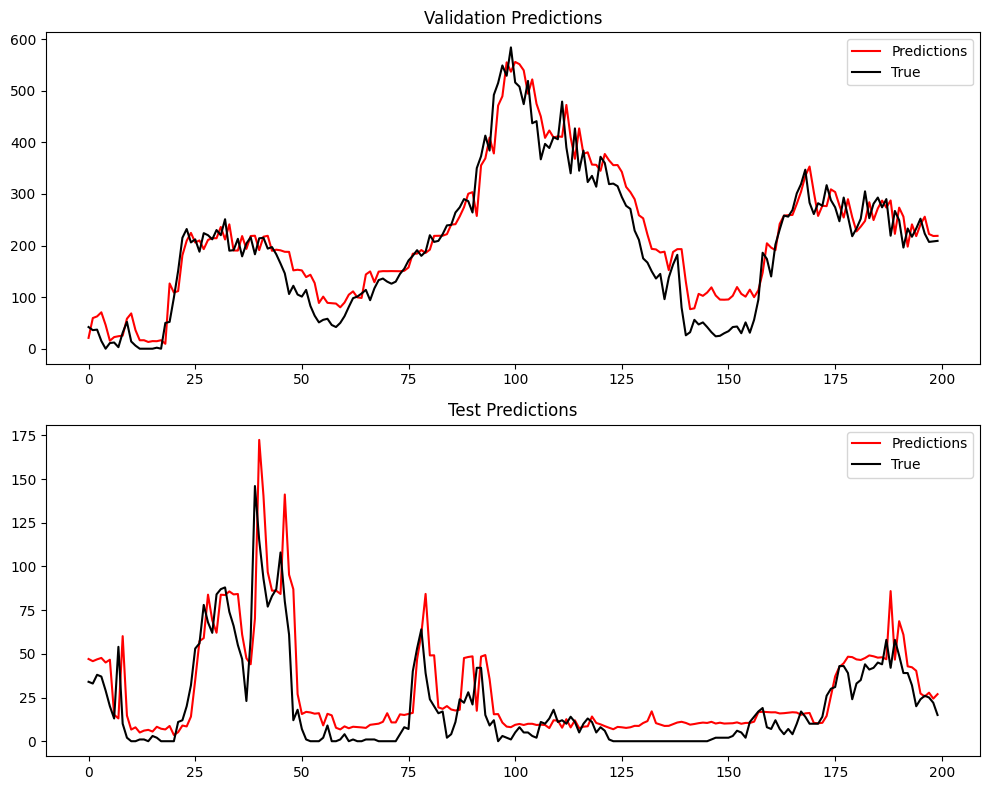

In [58]:
next_hour_rec_transfer,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)

## Next Day

## Default Recursive

In [59]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split,univariate=True,val_split=0.1)

In [60]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

Learning rate set to 0.091542
0:	learn: 212.3232847	test: 240.5060965	best: 240.5060965 (0)	total: 34.4ms	remaining: 34.4s
500:	learn: 53.1140171	test: 40.1492789	best: 39.9146202 (181)	total: 11.6s	remaining: 11.5s
999:	learn: 50.4144387	test: 40.5031358	best: 39.9146202 (181)	total: 23.1s	remaining: 0us
bestTest = 39.91462015
bestIteration = 181
Shrink model to first 182 iterations.


                   MAE        RMSE        R2
Validation   48.210898   72.874684  0.672441
Test        107.728677  142.285486  0.543361


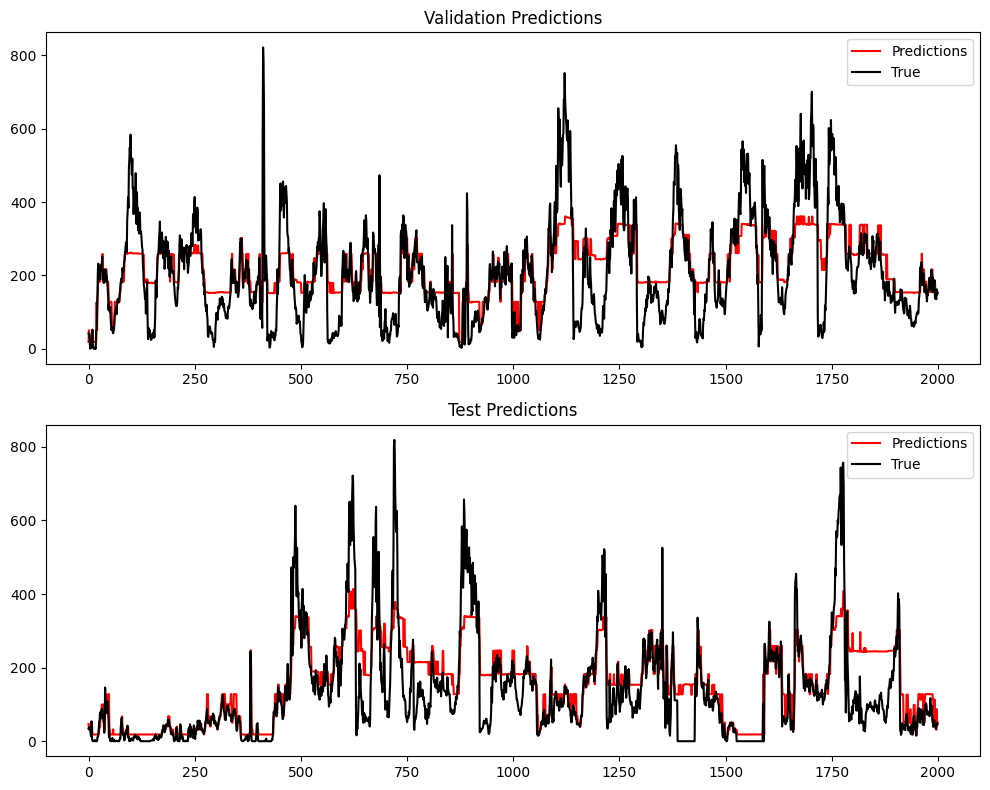

In [61]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =144)

### Recursive with Transferred Hyp-op

In [62]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

0:	learn: 218.6578503	test: 247.6320621	best: 247.6320621 (0)	total: 158ms	remaining: 2m 37s
500:	learn: 51.6893258	test: 39.7549899	best: 39.7170242 (381)	total: 45.5s	remaining: 45.3s
999:	learn: 48.7038744	test: 39.9299724	best: 39.7170242 (381)	total: 1m 31s	remaining: 0us
bestTest = 39.71702419
bestIteration = 381
Shrink model to first 382 iterations.


                   MAE        RMSE        R2
Validation   45.918971   71.821149  0.681843
Test        102.999416  136.212515  0.581509


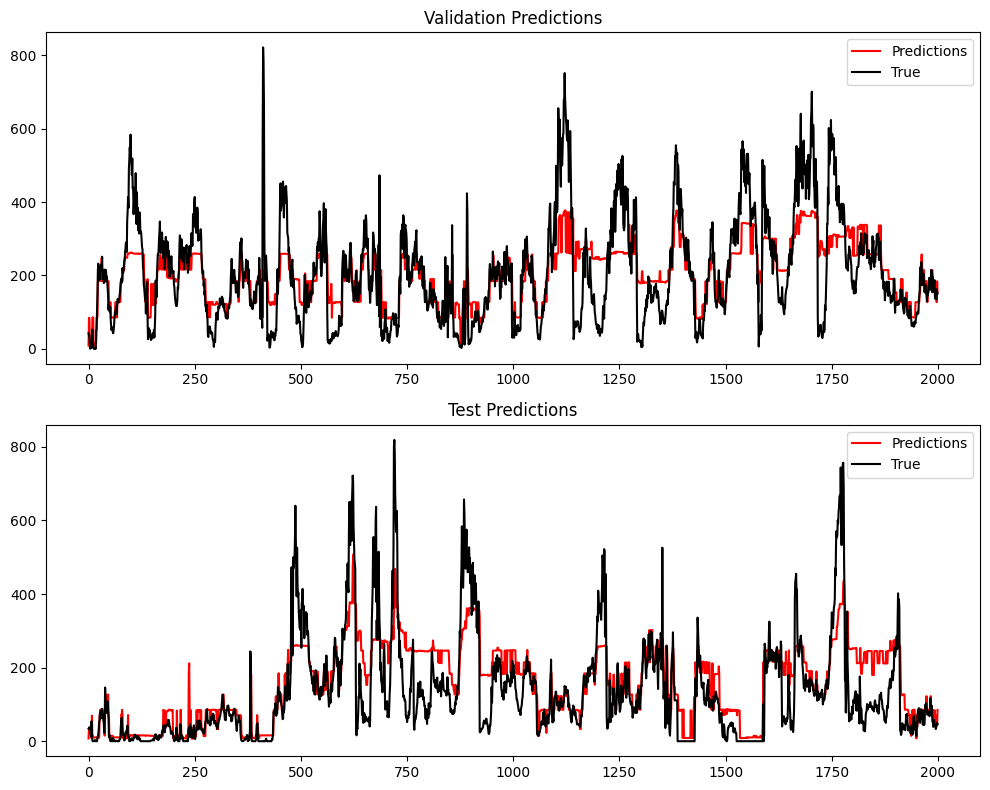

In [63]:
next_day_rec_transfer,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [69]:
next_step_baseline = {'MAE': 91.554 , 'RMSE': 145.603, 'R2':0 }
results = [next_step_baseline,next_step_os.iloc[1,:],next_step_os_feat.iloc[1,:],next_step_os_feat_hy.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', 'One Shot Feat + Hyp-op']

experiment_results(names, results,title = 'Next Step Prediction')

| Metric                 | MAE        | RMSE      | R2        |
|:-----------------------|:-----------|:----------|:----------|
| Next Step Prediction   |            |           |           |
| Baseline               | 91.554     | 145.603   | -         |
| One Shot               | 34.105     | 52.417    | 0.938     |
| One Shot Feat          | 33.558     | 51.983    | 0.939     |
| One Shot Feat + Hyp-op | **33.532** | **51.87** | **0.939** |


In [70]:
next_hour_baseline = {'MAE': 183.286 , 'RMSE': 263.749	, 'R2':0 }
results = [next_hour_baseline,next_hour_os.iloc[1,:],next_hour_os_feat.iloc[1,:],next_hour_os_feat_hy.iloc[1,:],next_hour_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Hour Prediction')

| Metric                 | MAE        | RMSE       | R2        |
|:-----------------------|:-----------|:-----------|:----------|
| Next Hour Prediction   |            |            |           |
| Baseline               | 183.286    | 263.749    | -         |
| One Shot               | 77.657     | 110.062    | 0.726     |
| One Shot Feat          | 78.138     | 110.56     | 0.724     |
| One Shot Feat + Hyp-op | 75.732     | 106.657    | 0.743     |
| Recursive              | **49.412** | **71.511** | **0.884** |


In [71]:
next_day_baseline = {'MAE': 510.710 , 'RMSE': 623.023	, 'R2':0 }
results = [next_day_baseline,next_day_os.iloc[1,:],next_day_os_feat.iloc[1,:],next_day_os_feat_hy.iloc[1,:], next_day_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Day Prediction')

| Metric                 | MAE         | RMSE        | R2        |
|:-----------------------|:------------|:------------|:----------|
| Next Day Prediction    |             |             |           |
| Baseline               | 510.71      | 623.023     | -         |
| One Shot               | 152.824     | 187.979     | 0.197     |
| One Shot Feat          | 151.73      | 188.445     | 0.193     |
| One Shot Feat + Hyp-op | 153.282     | 186.696     | 0.208     |
| Recursive              | **107.729** | **142.285** | **0.543** |


In [72]:
next_day_baseline = {'MAE': 510.710 , 'RMSE': 623.023	, 'R2':0 }
results = [ next_step_os_feat_hy.iloc[1,:],next_step_os_transfer.iloc[1,:],
            next_hour_os_feat_hy.iloc[1,:],next_hour_os_transfer.iloc[1,:],
            next_hour_rec.iloc[1,:],next_hour_rec_transfer.iloc[1,:]
            ,next_day_os_feat_hy.iloc[1,:],next_day_os_transfer.iloc[1,:]
           , next_day_rec.iloc[1,:],next_day_rec_transfer.iloc[1,:]]

names = ['Next step Hyp-op','Next step Transfer Hyp-op',
         'Next hour Hyp-op','Next hour Transfer Hyp-op',
         'Next hour Recursive', 'Next hour Recursive Transfer Hyp-op',
         'Next day Hyp-op','Next day Transfer Hyp-op',
         'Next day Recursive', 'Next day Recursive Transfer Hyp-op']

experiment_results(names, results,title = 'Transfer Prediction')

| Metric                              | MAE        | RMSE      | R2        |
|:------------------------------------|:-----------|:----------|:----------|
| Transfer Prediction                 |            |           |           |
| Next step Hyp-op                    | **33.532** | **51.87** | **0.939** |
| Next step Transfer Hyp-op           | 33.532     | 51.87     | 0.939     |
| Next hour Hyp-op                    | 75.732     | 106.657   | 0.743     |
| Next hour Transfer Hyp-op           | 75.758     | 106.963   | 0.741     |
| Next hour Recursive                 | 49.412     | 71.511    | 0.884     |
| Next hour Recursive Transfer Hyp-op | 50.6       | 72.057    | 0.883     |
| Next day Hyp-op                     | 153.282    | 186.696   | 0.208     |
| Next day Transfer Hyp-op            | 153.282    | 186.696   | 0.208     |
| Next day Recursive                  | 107.729    | 142.285   | 0.543     |
| Next day Recursive Transfer Hyp-op  | 102.999    | 136.213   | 0.582     |